<h1><center>Predictive Maintenance in PySpark</center></h1>
<h1><center>Notebook I: Data Preprocessing</center></h1>

In this notebook, we analysing datasets using **Apache Spark**. The use case used in this tutorial is Predictive Maintenance Analysis over Sensor Data.  

The dataset used in this tutorial is the **NASA Turbofan Engine Degradation Simulation** Dataset. This dataset is publically available for download under [this link](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/). 

Data home folder consists of 12 .txt files, representing four separate portions of train datasets, along with their corresponded test datasets and ground truth files. This tutorial analyses the first portion of data. But you are free to add aditional data portions and test them with the same code.  

We show how to **import data** into Apache Spark (PySpark) and prepare it for predictive analysis using different techniques. These techniques include **Removing Low Variance Features**, **Removing Noise** from Time-Series Data, **Normalize** and **Standardize** Data, and **Reduce Dimensionality** using **PCA method**. 

This notebook is divided into four main parts:
- [A. Import Data Into Spark](#A.-Import-Data-Into-Spark)
- [B. Data Labeling](#B.-Data-Labeling)
- [C. Feature Engineering](#C.-Feature-Engineering)
- [D. Save Data in Parquet Format](#D.-Save-Data-in-Parquet-Format)

This notebook is executable under [Python 2.7](https://www.python.org/download/releases/2.7/) and [Spark 2.3.2](https://spark.apache.org/releases/spark-release-2-3-2.html) versions.

In [1]:
import shutil
import os
import time
import re
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.window import Window
from pyspark.ml.feature import RFormula, PCA

# set data folder
path = 'CMAPSSData/'

<h2><center>A. Import Data Into Spark</center></h2>

In this part, we begin by cleaning the current directory from auto-generated data by previous sessions, then we create a Spark session and import data into **Resilient Distributed Datasets (RDDs)** objects. 


# Steps

- [A.1 Folder Cleaning](#A.1-Folder-Cleaning)
- [A.2 Launch Spark session](#A.2-Launch-Spark-session)
- [A.3 Read .CSV Data Files into RDD objects](#A.3-Read-.CSV-Data-Files-into-RDD-objects)
- [A.4 Convert RDDs to Spark Dataframes](#A.4-Convert-RDDs-to-Spark-Dataframes)
- [A.5 Remove NULL Values](#A.5-Remove-NULL-Values)
- [A.6 Set-Data-Types](#A.6-Set-Data-Types)
- [A.7 Count min and max obs. per engine per dataset](#A.7-Count-min-and-max-obs.-per-engine-per-dataset)

## A.1 Folder Cleaning
Starting from Spark 2.1.x, and due to default settings in Spark-defaults.conf.template file, Spark generate **metastore_db** directory and **derby.log** file automatically in the home folder of your code. Data resides in these components can interrupt the execution of the new Spark session. Accordingly, we begin by deleting both **metastore_db** directory and **derby.log** file, to enable Spark session to start properly. 

In [ ]:
def clean_project_directory():
    '''
    This function deletes both '/metastore_db' folder and 'derby.log' file before 
    initializing Apache Spark session.
    The goal is to avoid any inconsistant startout of Spark session
    '''

    print os.getcwd()

    # delete metastore_db folder if found
    if os.path.isdir(os.getcwd() + '/metastore_db'):
        shutil.rmtree(os.getcwd() + '/metastore_db', ignore_errors=True)

    # delete derby.log file if found
    if os.path.exists(os.getcwd() + '/derby.log'):
        os.remove(os.getcwd() + '/derby.log')

# run function
clean_project_directory()

## A.2 Launch Spark session
In this step, we create an instance of **Spark** module along with **sparkContext** object. We book **1 Gigabyte** of memory for the Spark session to be executed. 

In [3]:
def create_spark_session(app_name, exe_memory):
    '''
    This function creates Spark session with application name and available memory to the session
    
    INPUTS:
    @app_name: name of Spark application
    @exe_memory: value of reserved memory for Spark session
    
    OUTPUTS:
    @SparkSession instance
    '''
    
    # create Spark Session
    return SparkSession.builder \
       .master("local") \
       .appName(app_name) \
       .config("spark.executor.memory", exe_memory) \
       .getOrCreate()

# create Spark session    
spark = create_spark_session('Predictive Maintenance', '1gb')

# set Spark Context object
sc = spark.sparkContext

# print configurations of current Spark session
sc.getConf().getAll()

[(u'spark.master', u'local'),
 (u'spark.driver.port', u'41531'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.driver.host', u'192.168.1.103'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.app.name', u'Predictive Maintenance'),
 (u'spark.executor.id', u'driver'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.executor.memory', u'1gb'),
 (u'spark.app.id', u'local-1547036252185'),
 (u'spark.ui.showConsoleProgress', u'true')]

## A.3 Read .CSV Data Files into RDD objects
After launching our Spark session, we import .CSV train and test data files as RDD objects, and we print number of observations into each RDD object. 

In [4]:
def read_csv_as_rdd(sc, path, files_list, sep):
    '''
    This function reads .CSV data files into RDD object and returns the RDD object
    
    INPUTS:
    @sc: Spark Context object
    @path: path of .CSV files
    @files_list: list of :CVS data files
    @sep: fields separator
    
    OUTPUTS:
    @rdd: RDD object contains data observations
    '''
    
    # Read files and append them to RDD
    rdd = sc.union([sc.textFile(path + f) for f in files_list])

    # Split lines on spaces
    rdd = rdd.map(lambda line: line.split(sep))
    
    # return RDD object
    return rdd   

# get files of training data
train_files = sorted([filename for filename in os.listdir(path) if (filename.startswith('train') 
                                                              and filename.endswith('.txt'))])

# get files of test data
test_files = sorted([filename for filename in os.listdir(path) if (filename.startswith('test') 
                                                              and filename.endswith('.txt'))])

# read training data in RDD
train_rdd = read_csv_as_rdd(sc, path, [train_files[0]], " ")

# read test data in RDD
test_rdd = read_csv_as_rdd(sc, path, [test_files[0]], " ")

# print num. of observations of training data
print "number of observations in train data: ", train_rdd.count()

# print num. of observations of test data
print "number of observations in test data:  ", test_rdd.count()

number of observations in train data:  20631
number of observations in test data:   13096


## A.4 Convert RDDs to Spark Dataframes
In this step, we convert the RDD objects created above into Spark Dataframes, and we add columns' names to it. We also drop unnecessary columns added by empty spaces. Finally, we print dimensions of our Dataframes.

In [5]:
def convert_rdd_to_df(rdd, header):
    '''
    This function converts data from RDD format to Spark Dataframe, and adds header to the dataframe
    
    INPUTS:
    @rdd: RDD object contains data features
    @header: list of column names  
    
    OUTPUTS:
    PySpark DF version of @rdd
    '''
        
    # convert RDD to DF with header
    return rdd.toDF(header)

# Set data header, contains list of names of data columns
header = ["id", "cycle", "setting1", "setting2", "setting3",
                    "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8",
                    "s9", "s10", "s11", "s12", "s13", "s14", "s15", 
                    "s16","s17", "s18", "s19", "s20", "s21"]

# get df of both train and test data out of corresponded RDD objects
train_df = convert_rdd_to_df(train_rdd, header)
test_df = convert_rdd_to_df(test_rdd, header)

# drop empty columns from DF
train_df= train_df.drop("_27").drop("_28")
test_df= test_df.drop("_27").drop("_28")

# check the dimensions of the data
print train_df.count(), len(train_df.columns)
print test_df.count(), len(test_df.columns)

20631 26
13096 26


## A.5 Remove NULL Values
In this step, we check if our datasets contain NULL (empty) observations. If yes, we remove these entries. As the cell output shows, the data has no empty observations for both train and test datasets.

In [6]:
def remove_na_rows(df):
    '''
    This function removes rows with empty values from Spark Dataframe
    
    INPUTS:
    @df: Spark Dataframe with possible NULL values
    
    OUTPUTS:
    @df: Spark Dataframe without NULL values
    '''
    
    return df.na.drop()

# check the dimensions of the data
print "Before removing NULL rows:"
print train_df.count(), len(train_df.columns)
print test_df.count(), len(test_df.columns)

# remove empty rows
train_df = remove_na_rows(train_df)
test_df = remove_na_rows(test_df)

print "After removing NULL rows:"
# check the dimensions of the data
print train_df.count(), len(train_df.columns)
print test_df.count(), len(test_df.columns)

Before removing NULL rows:
20631 26
13096 26
After removing NULL rows:
20631 26
13096 26


## A.6 Set Data Types
In this step, we assign a data type to each column of our data. In the below cell, both **Integer** and **Double** data types are used. Other data types can be used, based on the dataset and use case.

In [7]:
def set_df_datatypes(df, int_list=[], dob_list=[]):
    '''
    This function convert columns data types to it's proper data types
    
    INPUTS:
    @df: Spark Dataframe
    @int_list: list of names of integer columns
    @dob_list: list of names of float/double columns
    
    OUTPUTS:
    @df: Spark Dataframe
    '''
    
    # loop over integer features/columns
    if len(int_list) > 0:
        for f in int_list:
            df = df.withColumn(f, df[f].cast(IntegerType()))
    
    # loop over double features/columns
    if len(dob_list) > 0:
        for f in dob_list:
            df = df.withColumn(f, df[f].cast(DoubleType()))
    
    # return dataframe with proper data types
    return df

# set integer and double columns names
int_list = ["id", "cycle"]

# get list of numerical variables
double_list = list(set(train_df.columns) - set(int_list))

# call function to set df data types
train_df = set_df_datatypes(train_df, int_list, double_list)
test_df = set_df_datatypes(test_df, int_list, double_list)

## A.7 Count min and max obs. per engine per dataset
In this step, we find engines with min/max numbers of observations, for both train and test datasets. As listed in the output, Engine #39 has the min number of observations (128) between all engines in train data, while Engine #69 has the max number of observations (362). As for test data, Engine #1 has (31) obsrvations [min], while Engine #49 has (303) observations [max]. 

In [8]:
print "For train data:"
# minimum entries per engine
train_df.groupBy('id').count().sort(F.col("count")).show(1)

# maximum entries per engine
train_df.groupBy('id').count().sort(F.col("count").desc()).show(1)

print "For test data:"
# minimum entries per engine
test_df.groupBy('id').count().sort(F.col("count")).show(1)

# maximum entries per engine
test_df.groupBy('id').count().sort(F.col("count").desc()).show(1)

For train data:
+---+-----+
| id|count|
+---+-----+
| 39|  128|
+---+-----+
only showing top 1 row

+---+-----+
| id|count|
+---+-----+
| 69|  362|
+---+-----+
only showing top 1 row

For test data:
+---+-----+
| id|count|
+---+-----+
|  1|   31|
+---+-----+
only showing top 1 row

+---+-----+
| id|count|
+---+-----+
| 49|  303|
+---+-----+
only showing top 1 row



<h2><center>B. Data Labeling</center></h2>

In this part, we add labels to observations in both train and test datasets. We have three types of labelings that serves three analytical branches: **Regression Analysis**, **Binary Classification**, and **Multi Classification**.



# Steps

- [B.1 Create RUL Labeling "Train Data"](#B.1-Create-RUL-Labeling-"Train-Data")
- [B.2 Create Windows Labeling  "Train Data"](#B.2-Create-Windows-Labeling-"Train-Data")
- [B.3 Create RUL Labeling "Test Data"](#B.3-Create-RUL-Labeling-"Test-Data")
- [B.4 Create Windows Labeling "Test Data"](#B.4-Create-Windows-Labeling-"Test-Data")
- [B.5 Data Visualization](#B.5-Data-Visualization)

## B.1 Create RUL Labeling "Train Data"
In this step, we add **Remaining Useful Life (RUL)** labels to both train and test datasets. Remaining Useful Life is an estimation of the number of time units (e.g. days/weeks/months), during which the machine can run properly before it fails completely. 

In our data, the RUL can be estimated by counting the number of daily observationds of each engine in descending order to estimate the number of days each Engine can run before a failure occur. 

RUL Labeling will be used in the regression analysis (see Notebook II)

In [9]:
def add_rul_labeling(df, idx, time):
    '''
    This function adds Remaining Useful Life (RUL) to assets (in our case, Aircraft Engines)
    
    INPUTS:
    @df: Spark Dataframe of Aircraft Engines
    @idx: column name of engines_ID
    @time: column name of operational time
    
    OUTPUTS:
    @df: Spark Dataframe after adding RUL column
    '''
    
    # create RUL Dataframe, by aggregating df Dataframe by engines_ID, and sorting it by operational time
    rul = df.groupBy([idx]).agg({time: "max"}).sort((idx))

    # change RUL dataframe columns' names
    rul = rul.toDF(idx, 'max')

    # merge RUL to df dataframe by 'idx' column
    df = df.join(rul, on=[idx], how= 'left')

    # calculate 'rul' column of dataframe, by subtracting operational time from max usage times of each engine
    df = df.withColumn('rul', df['max'] - df[time])

    # remove column 'max' from Dataframe
    df = df.drop('max')
    
    return df

#if file_type== "train":
# create RUL dataframe to save remain useful life of each engine
train_df = add_rul_labeling(train_df, 'id', 'cycle')

# check the dimensions of the data
#print df.count(), len(df.columns)

## B.2 Create Windows Labeling "Train Data"
In addition to the RUL labels, we create two other labelings to enable us build binary and multi classifiers to predict **Alarm** and **Warning** time zones before failures. For binary classification, we set the alarm window *w1* to 30 days before failure. For multi classification we set *w0* to 15 before failure, and *w1* to 15 days before Alarm zone, to represent **Alarm** and **Warning** zones, respectively.

In [10]:
def add_windows_labeling(df, w1, w0):
    '''
    This function adds windows labeling in ascending order.
    
    INPUTS:
    @df: Spark dataframe of assets features
    @w1: length of Alarm zone in time units
    @w0: length of Warning zone in time units
    
    OUTPUTS:
    @df: Spark Dataframe after adding windows columns
    '''
    
    # create first labeling window (binary classification)
    df = df.withColumn('label1', F.when(df.rul<=w1,1).otherwise(0)) 

    # create second labeling window (multi classification)
    df = df.withColumn('label2', df.label1)

    # compute second labeling window
    df = df.withColumn('label2',F.when(df.rul<=w0,2).otherwise(df.label2))
    
    return df

# set windows sizes of Alarm and Warning zones
w1 = 30
w0 = 15

# add windows labeling
train_df = add_windows_labeling(train_df,w1,w0)

## B.3 Create RUL Labeling "Test Data"
After adding multiple labels to train data observations, we apply the same labeling methodology to test dataset. Firstly, we add decreasing label per each engine life cycle, to represent RUL of test engines.

### B.3.1 Read .CSV Ground Truth RUL files
In this step, we read .CSV ground truth RUL data files into RDD objects, and we print number of rows into the aggregated RDD. Please note that we work with the first ground truth file that corresponds to the first train and test datasets. 

In [11]:
GT_file_type = "RUL"

# get files of test data
files = sorted([filename for filename in os.listdir(path) if filename.startswith(GT_file_type)])

# convert test data to RDD
rdd_gt = read_csv_as_rdd(sc, path, [files[0]], " ")

# print num. of observations
print rdd_gt.count()

100


### B.3.2 Create RUL label
In this step, we set RUL labeling into the ground truth dataframe

In [12]:
# Set ground truth column name
header_gt = ["rul"]

# get DF out of RDD object
df_gt = convert_rdd_to_df(rdd_gt, header_gt)

# drop empty columns from DF
df_gt= df_gt.drop("_2")

# check df_gt dimensions
print df_gt.count(), len(df_gt.columns)        

# convert URL column to integer
df_gt = df_gt.withColumn("rul", df_gt["rul"].cast(IntegerType()))

# create window to order Ground Truth DF by RUL
w = Window.orderBy(df_gt["rul"])

# create unique ID of Ground Truth DF
df_gt = df_gt.withColumn("id", F.row_number().over(w))

100 1


### B.3.3 Append RUL to Test Dataframe

After creating RUL labels, we append them to the test dataframe. The detailed steps are:

- **Create RUL Dataframe with index and value**
- **Merge RUL Dataframe with ground truth**
- **Compute total RUL**
- **Add RUL to test Dataframe**

In [13]:
# build RUL DF with index and value
rul = test_df.groupBy(["id"]).agg({"cycle": "max"}).sort(("id"))
rul = rul.toDF("id", 'max')

# merge rul df with ground truth
df_gt = df_gt.join(rul, on=["id"], how= 'left')

# compute total RUL
df_gt = df_gt.orderBy("id")
df_gt = df_gt.withColumn("total_rul", df_gt["rul"] + df_gt["max"])

# drop empty columns from DF
df_gt= df_gt.drop("rul").drop("max")

# ddd RUL to test Dataframe
test_df = test_df.join(df_gt, on=['id'], how='left')
test_df = test_df.withColumn('rul', test_df['total_rul'] - test_df['cycle'])
test_df = test_df.drop('total_rul')
test_df = test_df.orderBy("id","cycle")

## B.4 Create Windows Labeling "Test Data"
In addition to the RUL labeling, we create two windows labeling to enable us build binary and multi classifiers. The windows sizes are identical to those of train data labeling (See Section [B.2](#B.2-Create-Windows-Labeling-"Train-Data") above)

In [14]:
# set windows sizes of Alarm and Warning zones
w1 = 30
w0 = 15

# add windows labeling
test_df = add_windows_labeling(test_df,w1,w0)

# show example labelings
test_df.select(test_df['id'], test_df['rul'], test_df['label1'], test_df['label2']).show(30)

+---+---+------+------+
| id|rul|label1|label2|
+---+---+------+------+
|  1| 37|     0|     0|
|  1| 36|     0|     0|
|  1| 35|     0|     0|
|  1| 34|     0|     0|
|  1| 33|     0|     0|
|  1| 32|     0|     0|
|  1| 31|     0|     0|
|  1| 30|     1|     1|
|  1| 29|     1|     1|
|  1| 28|     1|     1|
|  1| 27|     1|     1|
|  1| 26|     1|     1|
|  1| 25|     1|     1|
|  1| 24|     1|     1|
|  1| 23|     1|     1|
|  1| 22|     1|     1|
|  1| 21|     1|     1|
|  1| 20|     1|     1|
|  1| 19|     1|     1|
|  1| 18|     1|     1|
|  1| 17|     1|     1|
|  1| 16|     1|     1|
|  1| 15|     1|     2|
|  1| 14|     1|     2|
|  1| 13|     1|     2|
|  1| 12|     1|     2|
|  1| 11|     1|     2|
|  1| 10|     1|     2|
|  1|  9|     1|     2|
|  1|  8|     1|     2|
+---+---+------+------+
only showing top 30 rows



## B.5 Data Visualization
After finishing data labeling, we visualize our train and test datasets. We begin with drowing simple plots to investigate the behaviour of each data feature over time. In order to achieve this goal, we need to query our PySpark DFs for features we need to plot, and convert the output of the query to Pandas DF. The following functions do this job for us. 

In [15]:
def get_pandasdf_from_sparkdf(spark_df, view_name, query):
    '''
    This function queries Spark DF, and returns the result table as Pandas DF
    
    INPUTS:
    @spark_df: Spark Dataframe to be queried
    @view_name: name of SQL view to be created from Spark Dataframe
    @query: SQL query to be run on @spark_df 
    
    OUTPUTS:
    SQL view of @query in Pandas format
    '''
    
    spark_df.createOrReplaceTempView(view_name)
    return spark.sql(query).toPandas()

def plot_pandas_ts(df, time_feature, start_col_idx, rows, cols, figsize_H, figsize_V, save_fig, file_name):
    '''
    This function plots grid of features against one feature (usually time).
    
    INPUTS:
    @df: Pandas DF with features to be plotted
    @time_feature: column name of time feature shared by all other features (plotted as x axis)
    @start_col_idx: index of the first column to be plotted
    @rows: number of rows in the grid
    @cols: number of columns in the grid
    @figsize_H: figure size (horizontal)
    @figsize_V: figure size (vertical)   
    @save_fig: boolean variable to check whether the figure will be saved or not
    @file_name: name of figure file to be saved
    '''
    
    # set time_feature as df index
    df.set_index(time_feature) 
    
    # init plot
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_H, figsize_V))
    
    # loop over featureas and add corresponded sub-plots
    for i in range(0,rows):
        for j in range(0,cols):
            
            df[df.iloc[:,start_col_idx].name].plot(ax=axes[i,j]); 
            axes[i,j].set_title(df.iloc[:,start_col_idx].name, fontweight='bold')           
            axes[i,j].set_xlim([0,len(df)])
            start_col_idx+= 1
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(file_name)

### B.5.1 Train Features Visualization

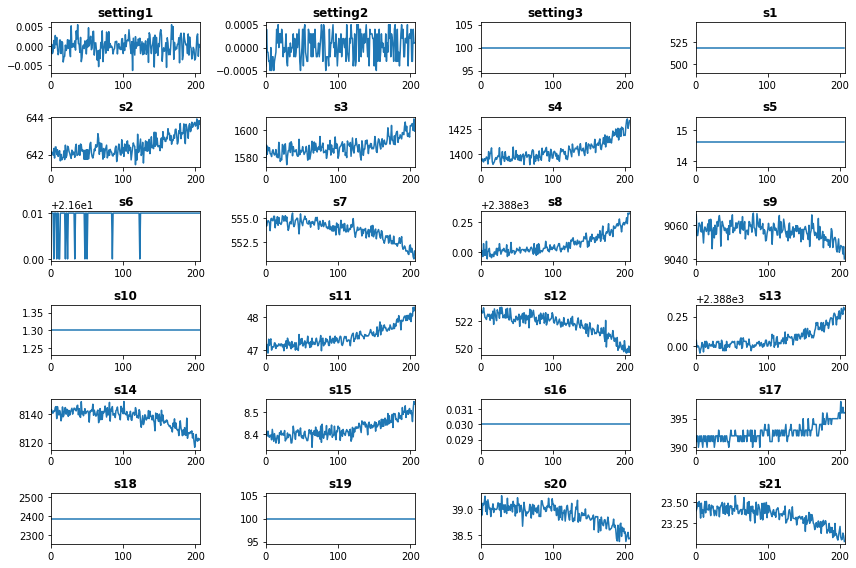

In [16]:
%matplotlib inline

# set SQL query for dataframe df
sqlQuery = """
    SELECT cycle, setting1, setting2, setting3,
                    s1, s2, s3, s4, s5, s6, s7, s8,
                    s9, s10, s11, s12, s13, s14, s15, 
                    s16,s17, s18, s19, s20, s21
    FROM df1 
    WHERE df1.id=15
    """

# get SQL query result as Pandas df
plotdata1 = get_pandasdf_from_sparkdf(train_df, "df1", sqlQuery)

# plot data
plot_pandas_ts(plotdata1, 'cycle', 1, 6, 4, 12, 8,  False, '')

### B.5.2 Test Features Visualization

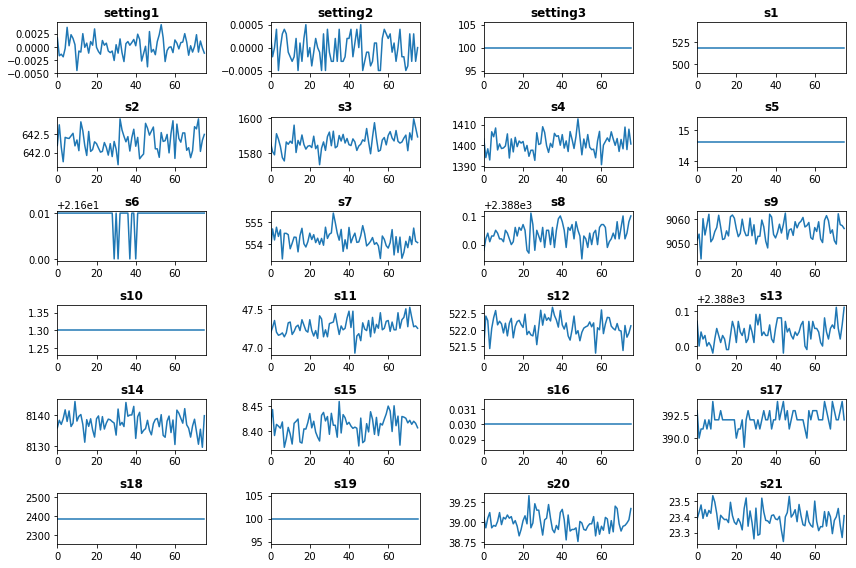

In [17]:
# get SQL query result as Pandas df
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df1", sqlQuery)

# plot data
plot_pandas_ts(plotdata2, 'cycle', 1, 6, 4, 12, 8, False, '')

<h2><center>C. Feature Engineering</center></h2>

In this part, we prepare our data to be modeled either for regression or classification. We start by **removing useless features** (i.e. features with low variance). Afterwards we apply moving average procedure to **overcome irregular observations**. We then add **normalized** and **standardized features** to our datasets. Finally we reduce data dimensionality by employing **Principal Component Analysis Algorithm (PCA)** to our data.


# Steps

- [C.1 Remove Low Variance Features](#C.1-Remove-Low-Variance-Features)
- [C.2 Remove Noise](#C.2-Remove-Noise)
- [C.3 Normalization](#C.3-Normalization)
- [C.4 Standardization](#C.4-Standardization)
- [C.6 Principal Component Analysis "PCA"](#C.6-Principal-Component-Analysis-"PCA")

## C.1 Remove Low Variance Features
We notice from the above visualizations that our datasets contains constant features that does not change over time. This type of features is useless in building predictive data models. Accordingly, we remove such features from our data sets. 

In [18]:
%%time
def spark_remove_low_var_features(spark_df, features, threshold, remove):
    '''
    This function removes low-variance features from features columns in Spark DF
    
    INPUTS:
    @spark_df: Spark Dataframe
    @features: list of data features in spark_df to be tested for low-variance removal
    @threshold: lowest accepted variance value of each feature
    @remove: boolean variable determine if the low-variance variable should be removed or not
    
    OUTPUTS:
    @spark_df: updated Spark Dataframe 
    @low_var_features: list of low variance features 
    @low_var_values: list of low variance values
    '''
        
    # set list of low variance features
    low_var_features = []
    
    # set corresponded list of low-var values
    low_var_values = []
    
    # loop over data features
    for f in features:
        # compute standard deviation of column 'f'
        std = float(spark_df.describe(f).filter("summary = 'stddev'").select(f).collect()[0].asDict()[f])
        
        # compute variance
        var = std*std

        # check if column 'f' variance is less of equal to threshold
        if var <= threshold:
            
            # append low-var feature name and value to the corresponded lists
            low_var_features.append(f)
            low_var_values.append(var)
            
            print(f + ': var: ' + str(var))
            
            # drop column 'f' if @remove is True
            if remove:
                spark_df = spark_df.drop(f)
    
    # return Spark Dataframe, low variance features, and low variance values
    return spark_df, low_var_features, low_var_values

# set non-features columns (id, time, labelings)
non_features_cols = ['id', 'cycle', 'rul', 'label1', 'label2']

# set rest of columns as data features
data_features = set(train_df.columns) - set(non_features_cols)

# remove low-variance features from data
print "For Training Data:"
train_df, train_low_var_features, train_low_var_values = spark_remove_low_var_features(train_df, data_features, 0.05, False)

print "\nFor Test Data:"
test_df, test_low_var_features, test_low_var_values = spark_remove_low_var_features(test_df, data_features, 0.05, False)

# remove union of low variance features of both training and test datasets
for f in sorted(list(set().union(train_low_var_features,test_low_var_features))):    
    train_df = train_df.drop(f)
    test_df = test_df.drop(f)

# check the dimensions of the data
print "\nTrain data dim:"
print train_df.count(), len(train_df.columns)

print "\nTest data dim:"
print test_df.count(), len(test_df.columns)

For Training Data:
s8: var: 0.00503893821336
setting1: var: 4.78434012424e-06
setting2: var: 8.58854088552e-08
setting3: var: 0.0
s1: var: 0.0
s6: var: 1.92927908773e-06
s5: var: 0.0
s19: var: 0.0
s18: var: 0.0
s13: var: 0.00517233043525
s10: var: 0.0
s16: var: 0.0
s15: var: 0.00140662787178
s20: var: 0.0326692711891
s21: var: 0.011718251883

For Test Data:
s8: var: 0.00329955856572
setting1: var: 4.85182156521e-06
setting2: var: 8.64539743867e-08
setting3: var: 0.0
s1: var: 0.0
s6: var: 2.9039048558e-06
s5: var: 0.0
s19: var: 0.0
s18: var: 0.0
s13: var: 0.0032415156918
s11: var: 0.0383835670111
s10: var: 0.0
s16: var: 0.0
s15: var: 0.000841541084646
s20: var: 0.0200734364238
s21: var: 0.00707622153346

Train data dim:
20631 13

Test data dim:
13096 13
CPU times: user 4.74 s, sys: 2.13 s, total: 6.87 s
Wall time: 4min 16s


### C.1.2 Train Features Visualization

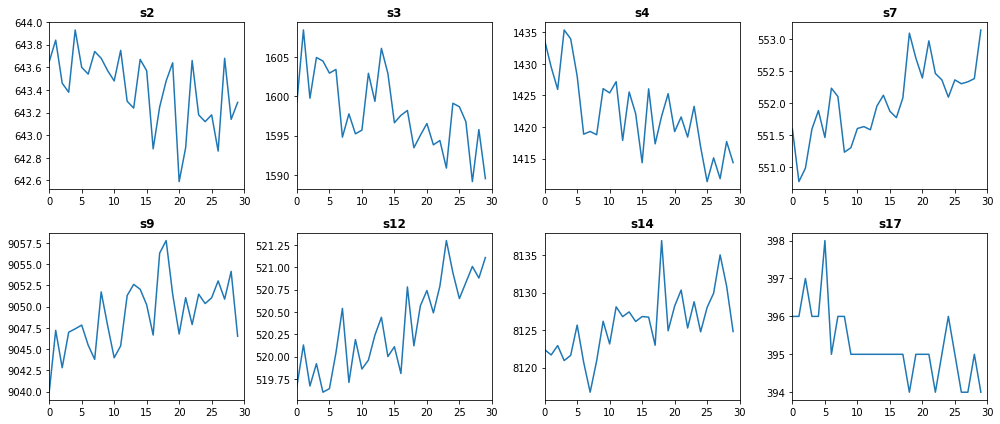

In [19]:
%matplotlib inline

# set SQL query for dataframe df
sqlQuery = """
    SELECT cycle, s2, s3, s4, s7, s9, s12, s14, s17
    FROM df1 
    WHERE df1.id=15 ORDER BY df1.cycle DESC LIMIT 30 
    """

# get SQL query result as Pandas df
plotdata1 = get_pandasdf_from_sparkdf(train_df, "df1", sqlQuery)

# plot data
plot_pandas_ts(plotdata1, 'cycle', 1, 2, 4, 14, 6,  True, 'fig_new/train_data_after_removing_low_var')

### C.1.3 Test Features Visualization

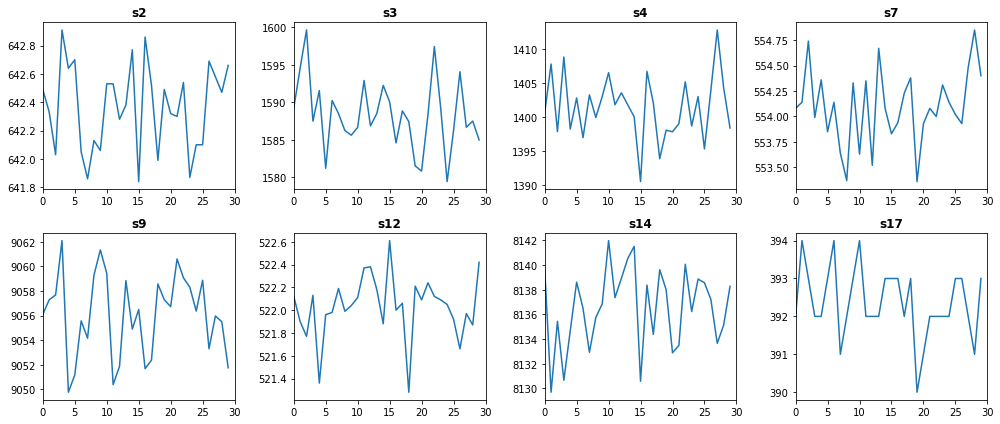

In [20]:
# get SQL query result as Pandas df
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df1", sqlQuery)

# plot data
plot_pandas_ts(plotdata2, 'cycle', 1, 2, 4, 14, 6,  True, 'fig_new/test_data_after_removing_low_var')

## C.2 Remove Noise
### C.2.1 Moving Average Procedure
Secondly, we apply moving average procedure to remove possible noise effects from sensor features. This procedure is essential in removing irregular sensor readings, and accordingly reaching smooth average data values over consecutive time domains. 

In [21]:
%%time
def add_rolling_avg_features(df, features, lags, idx, time):
    '''
    This function adds rolling average features for each asset in DF. The new features 
    take names OLD_FEATURE+'_rollingmean_'
    
    INPUTS:
    @df: Spark Dataframe
    @features: list of data features in @df
    @lags: list of windows sizes of rolling average method
    @idx: column name of asset ID 
    @time: column name of operational time
    
    OUTPUTS:
    @df: Updated Spark Dataframe
    '''
    
    # loop over window sizes
    for lag_n in lags:
        
        # create Spark window
        w = Window.partitionBy(idx).orderBy(time).rowsBetween(1-lag_n, 0)
        
        # loop over data features
        for f in features:
            
            # add new column of rolling average of feature 'f'
            df = df.withColumn(f + '_rollingmean_'+str(lag_n), F.avg(F.col(f)).over(w))
    
    # return DF
    return df

# update data features after low-variance removal
data_features = set(train_df.columns) - set(non_features_cols)

# set lag window to 4 cycles
lags = [4]

# add rolling average features
train_df = add_rolling_avg_features(train_df, data_features, lags, "id", "cycle")
test_df = add_rolling_avg_features(test_df, data_features, lags, "id", "cycle")

CPU times: user 23.9 ms, sys: 4.63 ms, total: 28.5 ms
Wall time: 503 ms


### C.2.2 Features Visualization After Removing Noise
After applying moving average procedure, we visualize our data again using the same plotting functions written above. The below plots describing the different features behaviours of engine #15.

In [22]:
%matplotlib inline

def sort_alphanumerically(s_list):
    '''
    this function sorts list of strings alphanumerically
    
    INPUTS:
    @s_list: list of strings
    
    OUTPUTS
    @s_list: list of strings sorted alphanumerically
    '''
    
    # convert numeric chars to numbers
    conv = lambda text: int(text) if text.isdigit() else text
    
    # set alphanumeric key to sort string begin with numbers
    alphanum_key = lambda key: [conv(c) for c in re.split('([0-9]+)', key)]
    
    # return sorted list using the alphanumeric key
    return sorted(s_list, key = alphanum_key)

def get_pandasdf_from_sparkdf(spark_df, view_name, query):
    '''
    this function queries Spark DF, and returns the result table as Pandas DF
    
    INPUTS:
    @spark_df: Spark DF to be queried
    @view_name: name of SQL view to be created from Spark DF
    @query: SQL query to be run on spark_df 
    '''
    
    spark_df.createOrReplaceTempView(view_name)
    return spark.sql(query).toPandas()

### C.2.3 Train Features Visualization

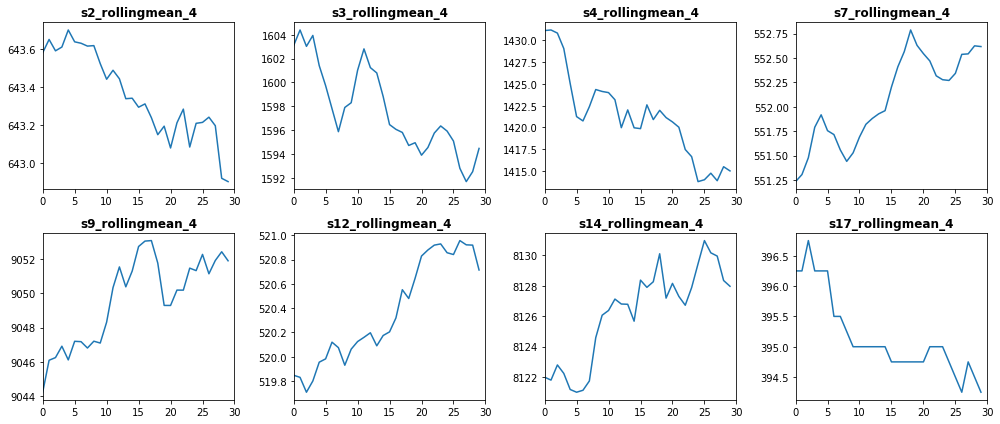

In [23]:
# get low-noise data features
roll_data_features = sort_alphanumerically([s for s in set(train_df.columns) if (s.endswith("rollingmean_4"))])

# set SQL query
sqlQuery2 = "SELECT cycle, " + \
', '.join(roll_data_features) + \
" FROM df4 WHERE df4.id=15 ORDER BY df4.cycle DESC LIMIT 30 "

# get SQL query result as Pandas df
plotdata1 = get_pandasdf_from_sparkdf(train_df, "df4", sqlQuery2)

# plot data
plot_pandas_ts(plotdata1, 'cycle', 1, 2, 4, 14, 6,  True, 'fig_new/train_data_after_removing_noise')

### C.2.4 Test Features Visualization

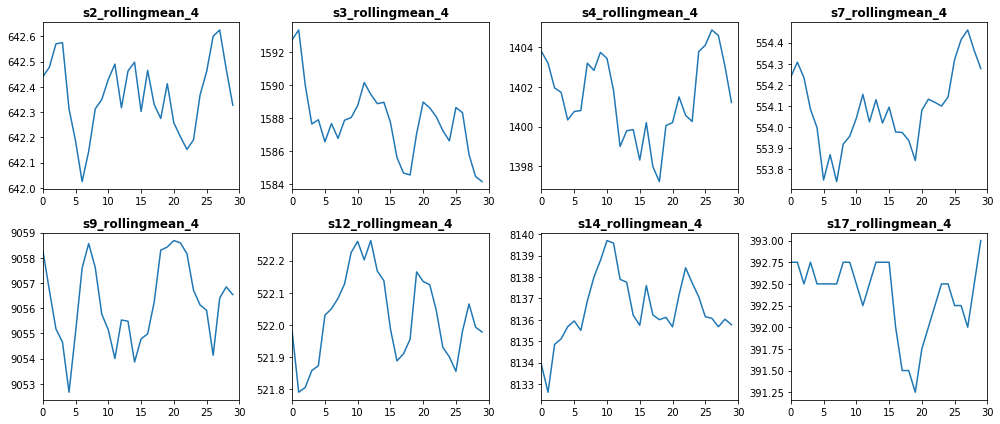

In [24]:
# get SQL query result as Pandas df
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df4", sqlQuery2)

# plot data
plot_pandas_ts(plotdata2, 'cycle', 1, 2, 4, 14, 6, True, 'fig_new/test_data_after_removing_noise')

## C.3 Normalization
In this step, we normalize data features by squashing each feature in [0,1] domain.

In [25]:
%%time

# Normalization
def add_normalized_features(df, features):
    '''
    This function squashes columns in Spark Dataframe in [0,1] domain.
    
    INPUTS:
    @df: Spark Dataframe
    @features: list of data features in spark_df  
    
    OUTPUTS:
    @df: Updated Spark Dataframe
    '''
    
    # create Spark window
    w = Window.partitionBy("id")
    
    for f in features:
        
        print f
        
        # compute noralized feature
        norm_feature = (F.col(f) - F.min(f).over(w)) / (F.max(f).over(w) - F.min(f).over(w))

        # add normalized feature to DF
        df = df.withColumn(f + '_norm', norm_feature) 

    return df

# add normalized features to df
train_df = add_normalized_features(train_df, roll_data_features)
test_df = add_normalized_features(test_df, roll_data_features)

s2_rollingmean_4
s3_rollingmean_4
s4_rollingmean_4
s7_rollingmean_4
s9_rollingmean_4
s12_rollingmean_4
s14_rollingmean_4
s17_rollingmean_4
s2_rollingmean_4
s3_rollingmean_4
s4_rollingmean_4
s7_rollingmean_4
s9_rollingmean_4
s12_rollingmean_4
s14_rollingmean_4
s17_rollingmean_4
CPU times: user 39.8 ms, sys: 23.4 ms, total: 63.2 ms
Wall time: 842 ms


### C.3.1 Features Visualization
In this section, we create queries to visualize normalized features in both train and test dataframes for engine #15.

In [26]:
# get normalized data features
norm_roll_data_features = sort_alphanumerically([s for s in set(train_df.columns) if (s.endswith("_norm"))])

sqlQuery3 = "SELECT cycle, " + \
', '.join(norm_roll_data_features) + \
" FROM df1 WHERE df1.id=15 ORDER BY df1.cycle "

### C.3.2 Train Features Visualization

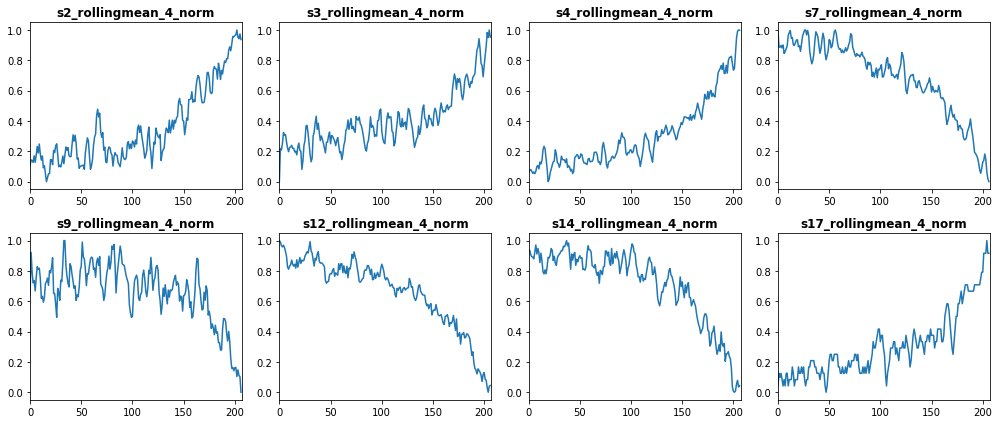

In [27]:
plotdata1 = get_pandasdf_from_sparkdf(train_df, "df1", sqlQuery3)

plot_pandas_ts(plotdata1, 'cycle', 1, 2, 4, 14, 6, True, 'fig_new/train_data_after_normalization')

### C.3.3 Test Features Visualization

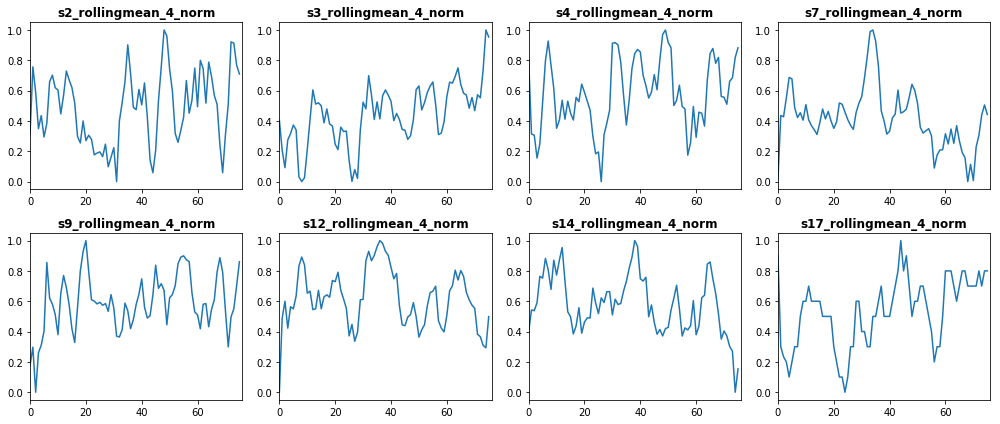

In [28]:
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df1", sqlQuery3)

plot_pandas_ts(plotdata2, 'cycle', 1, 2, 4, 14, 6, True, 'fig_new/test_data_after_normalization')

## C.4 Standardization
In this step, we standardize each feature to a new one, with 0 mean and unit standard deviation.

In [29]:
%%time

def add_standardized_features(df, features):
    '''
    This function add standard features with 0 mean and unit variance for each data feature in Spark DF
    
    INPUTS:
    @df: Spark Dataframe
    @features: list of data features in spark_df  
    
    OUTPUTS:
    @df: Updated Spark Dataframe
    '''
    
    # set windows range
    w = Window.partitionBy("id")
    
    # loop over features
    for f in features:        
        
        # compute scaled feature
        scaled_feature = (F.col(f) - F.mean(f).over(w)) / (F.stddev(f).over(w))
        
        # add standardized data features to DF
        df = df.withColumn(f + '_scaled', scaled_feature)      
        
    return df

# add standardized features to df
train_df = add_standardized_features(train_df, roll_data_features)
test_df = add_standardized_features(test_df, roll_data_features)

CPU times: user 28.4 ms, sys: 5.27 ms, total: 33.7 ms
Wall time: 766 ms


### C.4.1 Features Visualization
In this section, we create queries to visualize standerdized features in both train and test dataframes

In [30]:
# get standardized data features
scaled_roll_data_features = sort_alphanumerically([s for s in set(train_df.columns) if (s.endswith("_scaled"))])

# set SQL query
sqlQuery4 = "SELECT cycle, " + \
', '.join(scaled_roll_data_features) + \
" FROM df5 WHERE df5.id=15 ORDER BY df5.cycle"

### C.4.2 Train Features Visualization

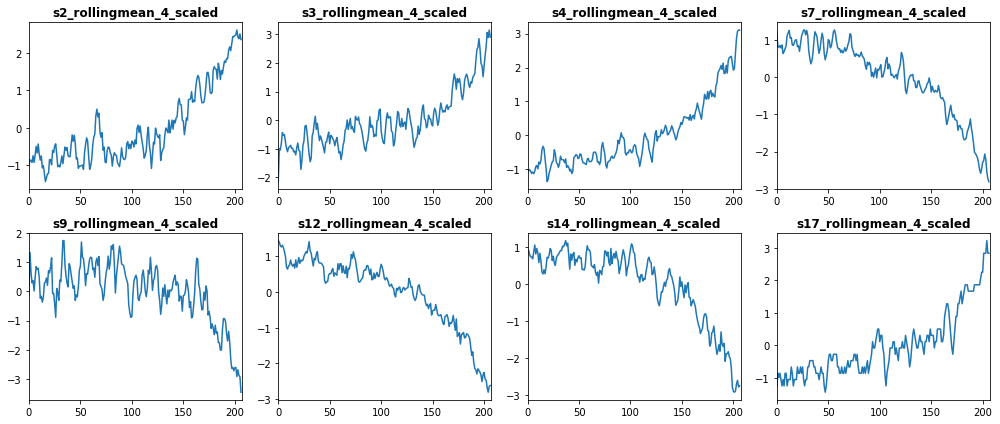

In [31]:
plotdata1 = get_pandasdf_from_sparkdf(train_df, "df5", sqlQuery4)

plot_pandas_ts(plotdata1, 'cycle', 1, 2, 4, 14, 6, True, 'fig_new/train_data_after_standardization')

### C.4.3 Test Features Visualization

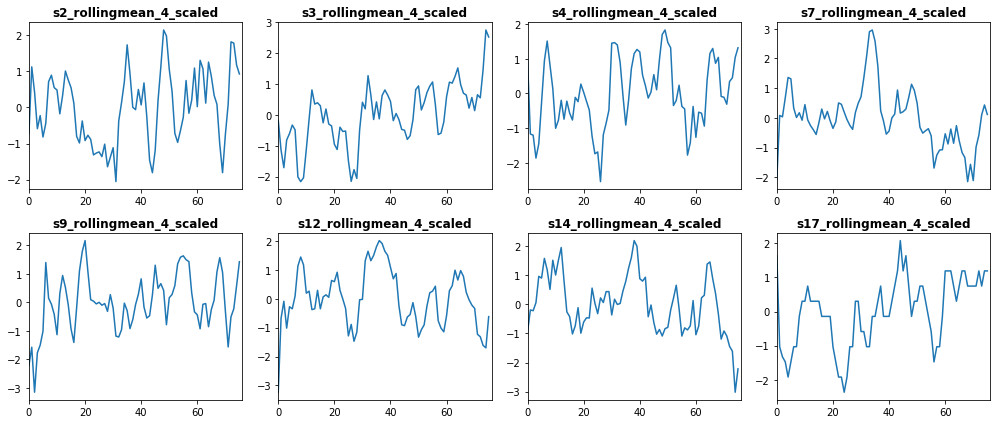

In [32]:
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df5", sqlQuery4)

plot_pandas_ts(plotdata2, 'cycle', 1, 2, 4, 14, 6, True, 'fig_new/test_data_after_standardization')

## C.5 Remove NULL Values
In this step, we check if data contains NULL (empty) rows. If yes, we remove these entries

In [33]:
%%time
# check the dimensions of the data
print "Train Data Before Removing NULL rows:"
print train_df.count(), len(train_df.columns)
print "Test Data Before removing NULL rows:"
print test_df.count(), len(test_df.columns)

# remove empty rows
train_df = remove_na_rows(train_df)
test_df = remove_na_rows(test_df)

print "\nTrain Data After Removing NULL rows:"
# check the dimensions of the data
print train_df.count(), len(train_df.columns)
print "Test Data After removing NULL rows:"
print test_df.count(), len(test_df.columns)

Train Data Before Removing NULL rows:
20631 37
Test Data Before removing NULL rows:
13096 37

Train Data After Removing NULL rows:
20631 37
Test Data After removing NULL rows:
13096 37
CPU times: user 413 ms, sys: 176 ms, total: 589 ms
Wall time: 51.3 s


## C.6 Principal Component Analysis "PCA"
After generating normalized and standardized features of our data, we apply PCA method to reduce number of dimensions. The below code calculates the first 10 principal components (PCs) of our data.

In [34]:
%%time

def extract(row):
    '''
    This function extract PC's features row by row as RDD object
    
    INPUTS:
    @row: 
    '''
    
    return (row.key, ) + tuple(float(x) for x in row.pcaFeatures.values)

def add_PCA_features(df, features, PC_num):
    '''
    This function add PCs to Spark dataframe.
    
    INPUTS:
    @df: Spark dataframe
    @features: list of data features in spark_df  
    @PC_num: number of required PCs
    
    OUTPUTS:
    @df_new: Updated Spark dataframe 
    @pca_variance: list of variances of PCA features
    '''
    
    # create unique ID for @df
    df = df.withColumn("key", F.monotonically_increasing_id())
    
    '''1. use RFormula to create the feature vector 
    In this step, we generate an ID column for scaled feature DF, and using this ID column to join data 
    features into one Vector.'''
    
    # Use RFormula to create feature vector
    formula = RFormula(formula = "~" + "+".join(features))

    # create ML pipeline for feature processing
    pipeline = formula.fit(df).transform(df)

    # select both "key" and "features" out of pipeline
    output = pipeline.select("key", "features")

    '''2. build PCA model, and fit data to it 
    In this step, we build a PCA model with 6 desired PCs, and train (fit) our features to that model. '''
    
    # init PCA object with "features" as input and "pcaFeatures" as output
    pca = PCA(k=PC_num, inputCol="features", outputCol="pcaFeatures")

    # build PCA model using output pipeline
    model = pca.fit(output)

    # get PCA result by fitting features into PCA
    result = model.transform(output).select("key", "pcaFeatures")

    # get vector of variances covered by each PC
    pca_variance = model.explainedVariance

    ''' 3. convert PCs to Dataframe columns** 
    In this step, we convert the generated PCs from last step, and append it to the scale data dataframe.
    '''
    
    # get PCA output as new Spark dataframe
    pca_outcome = result.rdd.map(extract).toDF(["key"])

    # get columns names of pca_outcome
    oldColumns = pca_outcome.schema.names

    # set new names for PCA features
    newColumns = ["key"]

    for i in range (1, PC_num + 1):
        newColumns.append('PCA_' + str(i))

    # add new columns names to PCA dataframe
    pca_result = reduce(lambda pca_outcome, idx: pca_outcome.withColumnRenamed(oldColumns[idx], newColumns[idx]), \
                                            xrange(len(oldColumns)), pca_outcome)

    # join PCA df to data df
    df_new = df.join(pca_result, 'key', 'left')
    
    return df_new, pca_variance

# set list of normalized and standardized data features
features_to_PCA = sort_alphanumerically([s for s in set(train_df.columns) if ("_4" in s)])

# add PCs to data features
train_df, train_pca_variance = add_PCA_features(train_df, features_to_PCA, 10)
print "Train Data PCA Variances: ", train_pca_variance

test_df, test_pca_variance = add_PCA_features(test_df, features_to_PCA, 10)
print "Test Data PCA Variances: ", test_pca_variance

Train Data PCA Variances:  [0.8890027882073337,0.09869774280953615,0.004824076095412,0.0038010595114653664,0.0012990284434409706,0.0011406486951147186,0.00047611721709097114,0.00021774192501472018,0.000196642264213761,0.00013742617937494153]
Test Data PCA Variances:  [0.7757189059656899,0.17005375664821154,0.01836501392450928,0.013639794465025513,0.007420013953235545,0.004470870722205577,0.0031655539619838543,0.0023694927918986148,0.001995691280838399,0.0017825102411198994]
CPU times: user 533 ms, sys: 199 ms, total: 732 ms
Wall time: 1min 19s


### C.6.1 PCA Variances Visualization
In this section, we visualize variances of generated PCA features 

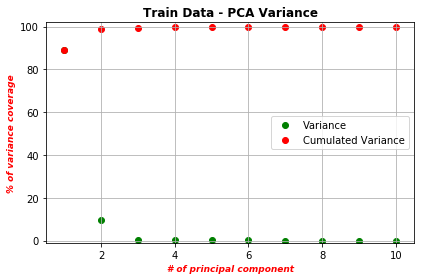

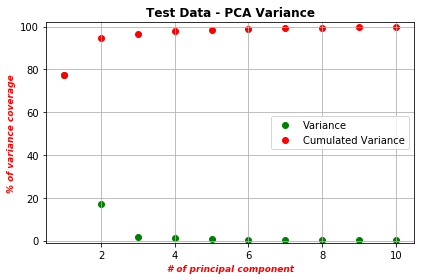

In [35]:
%matplotlib inline
def plot_PCA(pca_variance, title, save_fig, file_name):
    '''
    this function plots the variance ratio covered by each PC, given a vector of variances
    
    INPUTS:
    @pca_variance: vector of PC variances in range [0,1]
    @title: plot title
    @save_fig: boolean variable to check whether the figure will be saved or not
    @file_name: name of figure file to be saved
    '''
    
    n = len(pca_variance)
    plt.scatter(range(1,n+1),100*pca_variance, color= 'g', label='Variance')
    plt.scatter(range(1,n+1),100*np.cumsum(pca_variance), color= 'r', label='Cumulated Variance')
    
    axes = plt.gca()
    axes.set_xlim([.5, n+.5])
    axes.set_ylim([-1, 102])
    axes.set_title(title, fontsize= 12, fontweight= 'bold')
    axes.set_xlabel('# of principal component', fontsize= 9, fontweight= 'bold', style= 'italic', color= 'r')
    axes.set_ylabel('% of variance coverage', fontsize= 9, fontweight= 'bold', style= 'italic', color= 'r')
    axes.legend(ncol=1, loc=7)
    axes.grid()
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(file_name)
        
    plt.show()  
    
plot_PCA(train_pca_variance, 'Train Data - PCA Variance', False, '')
plot_PCA(test_pca_variance, 'Test Data - PCA Variance', False, '')

### Train PCs Visualization

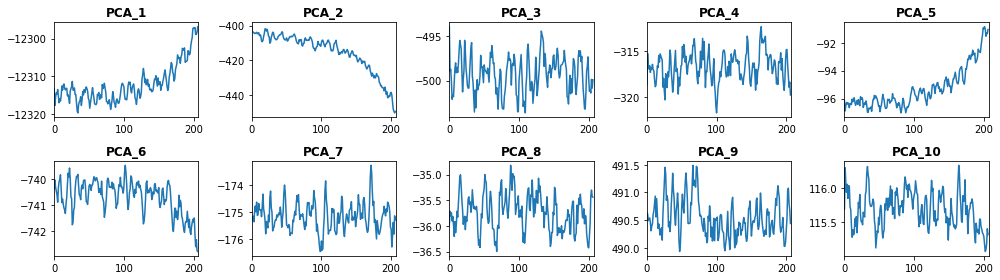

In [36]:
# get standardized data features
PC_features = sort_alphanumerically([s for s in set(train_df.columns) if ("PCA_" in s)])

# set SQL query
sqlQuery5 = "SELECT cycle, " + \
', '.join(PC_features) + \
" FROM df6 WHERE df6.id=15 ORDER BY df6.cycle"

plotdata1 = get_pandasdf_from_sparkdf(train_df, "df6", sqlQuery5)

plot_pandas_ts(plotdata1, 'cycle', 1, 2, 5, 14, 4, True, 'fig_new/train_PCs')

### Test PCs Visualization

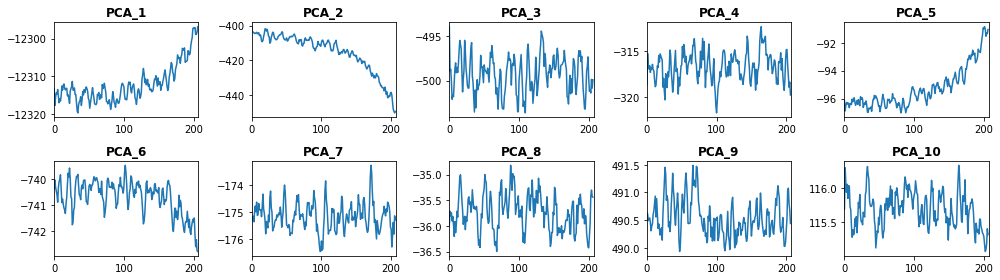

In [37]:
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df6", sqlQuery5)

plot_pandas_ts(plotdata1, 'cycle', 1, 2, 5, 14, 4, True, 'fig_new/test_PCs')

### C.6.2 Delete PCs Null Values
After generating PCs, we check whether the previous steps generate NULL values in our data. If yes, we delete these NULL values.

In [38]:
%%time
# check the dimensions of the data
print "Before removing NULL rows:"
print train_df.count(), len(train_df.columns)
print test_df.count(), len(test_df.columns)

# remove empty rows
train_df = remove_na_rows(train_df)
test_df = remove_na_rows(test_df)

print "After removing NULL rows:"
# check the dimensions of the data
print train_df.count(), len(train_df.columns)
print test_df.count(), len(test_df.columns)

Before removing NULL rows:
20631 48
13096 48
After removing NULL rows:
20631 48
13096 48
CPU times: user 592 ms, sys: 290 ms, total: 882 ms
Wall time: 3min 1s


### C.6.3 Normalize PCA Features
In this step, we normalize PC features in range [0,1]. The difference between this normalization and the above one is that this time we will calculate normalized features over the whole dataset, without partitioning per engines.

In [39]:
%%time

# Normalization
def add_normalized_features_unpartitioned(df, features):
    '''
    this function squashes columns in Spark dataframe in [0,1] domain.
    
    INPUTS:
    @df: Spark dataframe
    @features: list of data features in @df to be normalized
    
    OUTPUTS:
    @df: updated Spark Dataframe
    '''    
    
    # loop over data features
    for f in features:                                    
        # compute min, max values for data feature 'f'
        cur_min = df.agg({f: "min"}).collect()[0][0]
        cur_max = df.agg({f: "max"}).collect()[0][0]

        print f, ' cur_min: ', cur_min, ' cur_max: ', cur_max 

        # create UDF instance
        normalize_Udf = F.udf(lambda value: (value - cur_min) / (cur_max - cur_min), DoubleType())

        # build normalized DF of data features
        df = df.withColumn(f + '_norm', normalize_Udf(df[f])) 

    return df

# get PC features
pca_features = sort_alphanumerically([s for s in set(train_df.columns) if ("PCA_" in s and s.count('_') == 1)])

# add normalized features to df
print "Train Data:\n"
train_df = add_normalized_features_unpartitioned(train_df, pca_features)

print "\nTest Data:\n"
test_df = add_normalized_features_unpartitioned(test_df, pca_features)

Train Data:

PCA_1  cur_min:  -12538.8636627  cur_max:  -12272.2489635
PCA_2  cur_min:  -451.941055093  cur_max:  -395.172824022
PCA_3  cur_min:  -512.916713038  cur_max:  -485.903316932
PCA_4  cur_min:  -324.371109362  cur_max:  -303.603211704
PCA_5  cur_min:  -99.271876746  cur_max:  -90.1234331364
PCA_6  cur_min:  -745.675023887  cur_max:  -738.088217223
PCA_7  cur_min:  -179.36317414  cur_max:  -172.961431197
PCA_8  cur_min:  -38.0153292385  cur_max:  -33.8472794759
PCA_9  cur_min:  488.126375555  cur_max:  493.383062714
PCA_10  cur_min:  113.94914482  cur_max:  117.497177206

Test Data:

PCA_1  cur_min:  12109.9830666  cur_max:  12263.8723683
PCA_2  cur_min:  -2023.43692538  cur_max:  -1976.39872722
PCA_3  cur_min:  462.692059061  cur_max:  484.823452654
PCA_4  cur_min:  349.71939677  cur_max:  367.868245369
PCA_5  cur_min:  -863.915753303  cur_max:  -853.873431654
PCA_6  cur_min:  -331.877039917  cur_max:  -322.786198767
PCA_7  cur_min:  -106.159508309  cur_max:  -96.4748341657
P

### C.6.4 Standardize PCA Features
We also add standardized PC features to our datasets. 

In [40]:
%%time
def add_standardized_features_unpartitioned(df, features):
    '''
    this function add standard features with 0 mean and unit variance for each data feature in Spark DF
    
    INPUTS:
    @df: Spark Dataframe
    @features: list of data features in @df to be standerdized
    
    OUTPUTS:
    @df: updated Spark Dataframe 
    '''
    
    for f in features:
        # compute min, max values for each data feature
        cur_mean = float(df.describe(f).filter("summary = 'mean'").select(f).collect()[0].asDict()[f])
        cur_std = float(df.describe(f).filter("summary = 'stddev'").select(f).collect()[0].asDict()[f])

        print f, ' cur_mean: ', cur_mean, ' cur_std: ', cur_std 

        # create UDF instance step 1 (subtract mean from feature)
        standardize_Udf = F.udf(lambda value: (value - cur_mean) / cur_std, DoubleType())

        # add standardized data features
        df = df.withColumn(f + '_scaled', standardize_Udf(df[f]))  
        
    return df

# get PC features
pca_features = sort_alphanumerically([s for s in set(train_df.columns) if ("PCA_" in s and s.count('_') == 1)])

# add standardized features to df
print "Train Data:"
train_df = add_standardized_features_unpartitioned(train_df, pca_features)

print "\nTest Data:"
test_df = add_standardized_features_unpartitioned(test_df, pca_features)

Train Data:
PCA_1  cur_mean:  -12323.3086514  cur_std:  27.9765858472
PCA_2  cur_mean:  -419.587121565  cur_std:  9.32173521444
PCA_3  cur_mean:  -498.739145779  cur_std:  2.06086824365
PCA_4  cur_mean:  -316.719030202  cur_std:  1.82934445008
PCA_5  cur_mean:  -95.6237026148  cur_std:  1.06943029448
PCA_6  cur_mean:  -742.01845975  cur_std:  1.00211856135
PCA_7  cur_mean:  -175.371530939  cur_std:  0.647440846958
PCA_8  cur_mean:  -35.8808724124  cur_std:  0.437838735972
PCA_9  cur_mean:  490.471692795  cur_std:  0.416084545696
PCA_10  cur_mean:  115.753613407  cur_std:  0.347838691548

Test Data:
PCA_1  cur_mean:  12145.8957  cur_std:  14.2254791979
PCA_2  cur_mean:  -1995.12477757  cur_std:  6.66051532617
PCA_3  cur_mean:  474.976306417  cur_std:  2.18882150912
PCA_4  cur_mean:  359.280243536  cur_std:  1.88633416081
PCA_5  cur_mean:  -858.942482152  cur_std:  1.39128812322
PCA_6  cur_mean:  -327.210955903  cur_std:  1.07996771543
PCA_7  cur_mean:  -101.557274291  cur_std:  0.908739

<h2><center>D. Save Data in Parquet Format</center></h2>

Adding PCs was the last data preprocessing step of this tutorial. Now we save train and test dataframes in a parquet format, to be used in the second notebook of this tutorial.

Parquet is a columnar storage format supported by Spark. It is very efficient in case you want to store large datasets with many columns. 

In [41]:
%%time

# save Dataframes as Parquet
train_df.write.mode('overwrite').parquet(os.getcwd() + '/' + path +  'train_FD001_preprocessed.parquet')
test_df.write.mode('overwrite').parquet(os.getcwd() + '/' + path +  'test_FD001_preprocessed.parquet')

CPU times: user 319 ms, sys: 106 ms, total: 425 ms
Wall time: 2min 2s
